In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import pandas as pd

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    pred_list = []
    target_list = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            pred_list.extend(torch.flatten(pred).tolist())
            target_list.extend(target.tolist())

    test_loss /= len(test_loader.dataset)


    pred_list = pd.Series(pred_list, name='Actual')
    target_list = pd.Series(target_list, name='Predicted')
    cm = pd.crosstab(target_list, pred_list)

    print(cm)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
use_cuda = True
use_mps = False
test_batch_size = 1000

use_cuda = not use_cuda and torch.cuda.is_available()
use_mps = not use_mps and torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
dataset2 = datasets.MNIST("../data", train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)



In [8]:

model = Net().to(device)
model.load_state_dict(torch.utils.model_zoo.load_url("https://rsekube.nrp-nautilus.io/mnist_cnn.pt", model_dir=".", map_location=device))
test(model, device, test_loader)

Downloading: "https://rsekube.nrp-nautilus.io/mnist_cnn.pt" to ./mnist_cnn.pt
100.0%


Actual       0     1     2     3    4    5    6     7    8    9
Predicted                                                      
0          978     0     0     0    0    0    1     1    0    0
1            0  1133     0     1    0    0    0     1    0    0
2            2     3  1020     0    0    0    0     6    1    0
3            0     0     1  1006    0    2    0     0    1    0
4            0     0     0     0  976    0    2     0    1    3
5            2     0     0     5    0  883    2     0    0    0
6            4     2     0     0    1    3  946     0    2    0
7            0     2     4     1    0    0    0  1018    1    2
8            4     1     2     1    0    0    0     2  963    1
9            1     2     0     0    4    6    0     4    2  990

Average loss: 0.0288, Accuracy: 9913/10000 (99%)



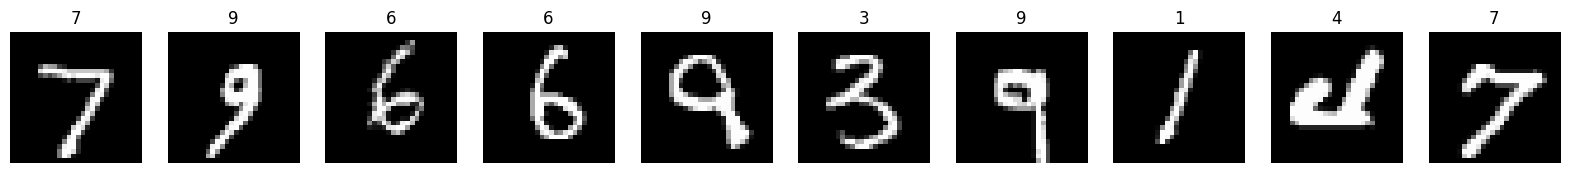

In [9]:
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for idx,(test_images, test_labels) in enumerate(test_loader):  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]
    ax[idx].imshow(sample_image[0], cmap='gray')
    ax[idx].set_title(f'{sample_label}')
    ax[idx].axis('off')